# DA5401 A7: Multi-Class Model Selection using ROC and Precision-Recall Curves 

### ✅ Import required libraries


In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Dummy and ML classifiers
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Multi-class strategy
from sklearn.multiclass import OneVsRestClassifier

import numpy as np

# Performance metrics
from sklearn.metrics import (
    accuracy_score, f1_score,
    precision_recall_curve, average_precision_score,
    roc_auc_score, roc_curve, auc
)
# Hyperparameter search
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Binarize labels for multi-class PRC/ROC
from sklearn.preprocessing import label_binarize


## Part A: Data Preparation and Baseline

### 📂 Load training and test dataset paths

In [3]:
# File paths for Satellite Image dataset (training & test splits)
train_path = "sat.trn"   # Path to training data file
test_path  = "sat.tst"   # Path to testing data file


### 📄 Load dataset into Pandas DataFrames

In [4]:
col_names=[f"band{i+1}" for i in range(36)]+["label"]
train_df = pd.read_csv(train_path,sep=r"\s+",header=None,names=col_names)
test_df= pd.read_csv(test_path,sep="\s+",header=None,names=col_names)
print(f"train_df_shape:{train_df.shape}")
train_df.sample(5)

train_df_shape:(4435, 37)


,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band28,band29,band30,band31,band32,band33,band34,band35,band36,label
477,88,103,108,88,88,107,108,88,88,107,...,85,82,96,104,81,90,104,108,85,3
2440,68,77,82,65,64,73,78,61,64,73,...,62,67,79,81,62,67,72,77,58,7
2955,74,92,97,80,70,79,82,65,60,63,...,92,88,107,118,92,84,103,108,88,3
3268,53,92,105,87,57,88,105,87,60,97,...,78,50,79,96,78,56,87,104,92,1
2199,80,99,104,78,76,95,96,78,71,87,...,70,78,91,96,78,74,91,92,78,4


In [5]:
print(f"test_df.shape:{test_df.shape}")
test_df.sample(5)

test_df.shape:(2000, 37)


,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band28,band29,band30,band31,band32,band33,band34,band35,band36,label
1348,60,63,78,62,60,71,85,69,60,63,...,59,64,75,91,78,71,87,100,81,5
1099,76,91,96,74,76,91,96,74,76,91,...,74,56,53,80,66,59,53,73,63,5
884,44,34,109,112,41,37,104,116,41,32,...,113,46,34,93,105,49,37,97,98,2
1003,75,99,109,87,79,111,123,100,75,111,...,86,75,112,119,101,79,112,124,101,1
1417,75,99,109,96,75,99,113,92,75,107,...,86,59,91,101,86,59,95,110,90,1


### 📊 Visualize class distribution in Train vs Test sets (with percentages)


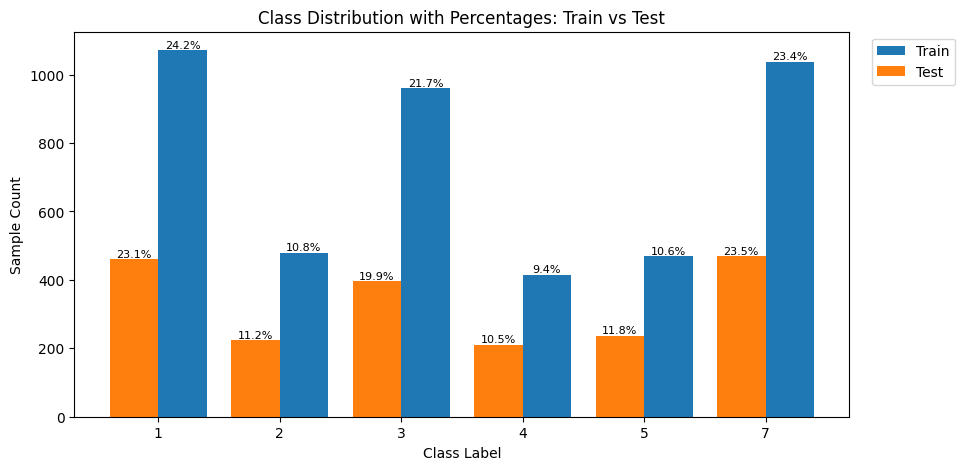

In [6]:
# Count class distribution for train & test sets
train_counts = train_df['label'].value_counts().sort_index()
test_counts  = test_df['label'].value_counts().sort_index()

# Compute percentage distribution
train_pct = (train_counts / train_counts.sum()) * 100
test_pct  = (test_counts / test_counts.sum()) * 100

# Create side-by-side bar plot
plt.figure(figsize=(10,5))
x = range(len(train_counts))

# Plot bars (train on right, test on left)
train_bars = plt.bar(x, train_counts.values, width=0.4, label='Train', align='edge')
test_bars  = plt.bar([i-0.4 for i in x], test_counts.values, width=0.4, label='Test', align='edge')

# Annotate each bar with percentage value
for bar, pct in zip(train_bars, train_pct):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{pct:.1f}%",
             ha='center', va='bottom', fontsize=8)

for bar, pct in zip(test_bars, test_pct):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{pct:.1f}%",
             ha='center', va='bottom', fontsize=8)

# Customize plot labels and legend
plt.xticks(x, train_counts.index)
plt.xlabel("Class Label")
plt.ylabel("Sample Count")
plt.title("Class Distribution with Percentages: Train vs Test")

# Move legend outside plot
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.show()


#### 📊 Interpretation: Class Distribution in Train vs Test Sets

The above bar chart visualizes the **class distribution** across the training and test datasets for the satellite imagery classification task.

- Class **6** is absent from both **training and test** data.
- Classes **1**, **3**, and **7** are the **most frequent**, together accounting for over 65% of total samples in both splits.  
- Classes **2**, **4**, and **5** occur less frequently, indicating **moderate class imbalance**.
- The overall distribution pattern between training and test sets is **similar**, confirming that the split was **stratified or balanced** across classes.
- However, **minor proportional differences** (e.g., Class 1 slightly higher in train set) may still impact model calibration.
- This distribution suggests the need for **class-weighted training** or **weighted evaluation metrics** such as *Weighted F1* or *Weighted AUC* to ensure fair performance across minority classes.


### 🧹 Check for missing values and duplicate rows in Train/Test datasets


In [7]:
# Count total null (missing) values in train and test data
train_null = train_df.isnull().sum().sum()   # total nulls in training set
test_null = test_df.isnull().sum().sum()     # total nulls in test set

# Count duplicate rows in train and test data
train_duplicates = train_df.duplicated().sum()   # duplicated rows in training set
test_duplicates  = test_df.duplicated().sum()    # duplicated rows in test set

train_null, test_null, train_duplicates, test_duplicates


(0, 0, 0, 0)

#### 🧹 Interpretation: Data Quality Check (Nulls & Duplicates)

The dataset shows:

- **0 null (missing) values** in both the training and test sets.  
- **0 duplicate rows** in both datasets.

✅ This confirms that the satellite dataset is **clean and well-structured**, requiring **no preprocessing for missing or redundant entries**.  
Such consistency ensures that any differences in model performance are due to **feature or class distribution**, not data quality issues.


### Split features & labels and 🔄 Standardize feature values

In [8]:
# Separate features (X) and target labels (y) for train & test sets
x_train = train_df.drop("label", axis=1)
y_train = train_df["label"]

x_test  = test_df.drop("label", axis=1)
y_test  = test_df["label"]

# Standardize features using only training statistics (important to avoid data leakage)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)   # fit on train, transform train
x_test_scaled  = scaler.transform(x_test)        # only transform test

# Convert scaled arrays back to DataFrame for readability
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns)
x_test_scaled  = pd.DataFrame(x_test_scaled, columns=x_test.columns)

# Display descriptive statistics of standardized training data
x_train_scaled.describe()


,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band27,band28,band29,band30,band31,band32,band33,band34,band35,band36
count,4.435000e+03,4.435000e+03,4.435000e+03,4.435000e+03,4.435000e+03,4.435000e+03,4.435000e+03,4.435000e+03,4.435000e+03,4.435000e+03,...,4.435000e+03,4.435000e+03,4.435000e+03,4.435000e+03,4.435000e+03,4.435000e+03,4.435000e+03,4.435000e+03,4.435000e+03,4.435000e+03
mean,4.357782e-16,1.538041e-16,-1.057403e-16,-1.922551e-16,2.307061e-16,-2.691571e-16,-2.787699e-16,3.845102e-17,-3.716932e-16,6.408503e-17,...,9.612754e-17,1.666211e-16,-3.588762e-16,8.971904e-17,-2.819741e-16,1.473956e-16,1.025360e-16,2.307061e-16,-7.049353e-17,-3.204251e-16
std,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,...,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00
min,-2.159566e+00,-2.502154e+00,-2.598809e+00,-2.650975e+00,-2.155488e+00,-2.477042e+00,-2.957740e+00,-2.858061e+00,-2.146025e+00,-2.460727e+00,...,-2.773993e+00,-2.577770e+00,-2.219350e+00,-2.474155e+00,-2.938212e+00,-2.832348e+00,-2.143234e+00,-2.467181e+00,-2.945073e+00,-2.836149e+00
25%,-6.941596e-01,-5.657491e-01,-8.591866e-01,-6.716606e-01,-6.795709e-01,-5.479989e-01,-8.525664e-01,-7.204136e-01,-6.641412e-01,-5.318110e-01,...,-8.577841e-01,-6.712121e-01,-6.675194e-01,-5.451353e-01,-8.473306e-01,-7.201570e-01,-6.547255e-01,-5.339747e-01,-8.440889e-01,-7.190053e-01
50%,-1.079973e-01,1.383983e-01,1.006050e-01,2.377421e-02,-8.920397e-02,6.578755e-02,1.097986e-01,-7.911946e-02,-1.454819e-01,8.193494e-02,...,1.003201e-01,-8.865269e-02,-7.634601e-02,6.864359e-02,1.085009e-01,-8.649980e-02,-1.337476e-01,8.113641e-02,5.633305e-02,-8.386227e-02
75%,7.712463e-01,8.425457e-01,8.204486e-01,5.052290e-01,7.963464e-01,8.549415e-01,8.315723e-01,5.087335e-01,7.436483e-01,8.710369e-01,...,8.188983e-01,4.939068e-01,7.734658e-01,8.577879e-01,8.253745e-01,4.943526e-01,7.593574e-01,8.719935e-01,8.366987e-01,4.983522e-01
max,2.529733e+00,2.338859e+00,2.440097e+00,3.821918e+00,2.419855e+00,2.345566e+00,2.756302e+00,3.982410e+00,2.596003e+00,2.054690e+00,...,2.435699e+00,3.777424e+00,2.583934e+00,1.953822e+00,2.737037e+00,3.926662e+00,2.619993e+00,2.058279e+00,2.757599e+00,3.938710e+00


### 🤖 Train baseline & ML models and evaluate with Accuracy + Weighted F1


In [9]:
# Dictionary of models to train (multi-class settings where needed)
models = {
    "Dummy (Prior)": DummyClassifier(strategy="prior"),  # baseline model (prior class distribution)
    "Logistic Regression": OneVsRestClassifier(
        LogisticRegression(max_iter=1000, class_weight='balanced') # OvR with class balancing
    ),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),   # KNN classifier (k=5)
    "Decision Tree": DecisionTreeClassifier(),          # CART Decision Tree
    "Naive Bayes": GaussianNB(),                        # Gaussian NB
    "SVC": SVC(probability=True)                        # Support Vector Classifier with probability scores
}

results = []  # list to store metrics

# Train each model and compute accuracy & weighted F1-score
for name, model in models.items():
    model.fit(x_train_scaled, y_train)                        # train model
    y_pred = model.predict(x_test_scaled)                    # predict on test data
    acc = accuracy_score(y_test, y_pred)                     # accuracy score
    f1 = f1_score(y_test, y_pred, average="weighted")        # weighted F1-score for class imbalance
    results.append([name, acc, f1])                          # store results

# Convert results to DataFrame for clean display
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Weighted F1 Score"])
results_df

,Model,Accuracy,Weighted F1 Score
0,Dummy (Prior),0.2305,0.086356
1,Logistic Regression,0.8300,0.820846
2,KNN (k=5),0.9045,0.903748
3,Decision Tree,0.8560,0.856935
4,Naive Bayes,0.7965,0.803581
5,SVC,0.8955,0.892490


### 📊 Compare model performance using Accuracy vs Weighted F1 Score (bar plot)


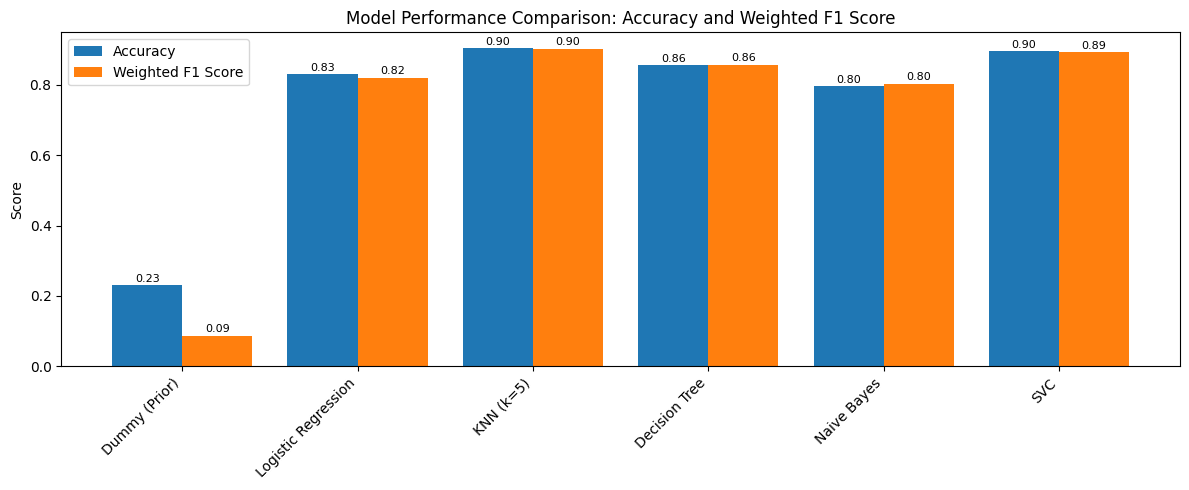

In [10]:
# Extract model names and metric columns from results dataframe
model      = results_df["Model"]
accuracy   = results_df["Accuracy"]
f1_scores  = results_df["Weighted F1 Score"]

# X positions for bar groups
x = np.arange(len(models))
width = 0.4  # width of each bar

plt.figure(figsize=(12,5))

# Plot accuracy bars
plt.bar(x - width/2, accuracy, width, label='Accuracy')

# Plot weighted F1-score bars
plt.bar(x + width/2, f1_scores, width, label='Weighted F1 Score')

# Formatting labels, title, and x-axis ticks
plt.xticks(x, model, rotation=45, ha='right')
plt.ylabel("Score")
plt.title("Model Performance Comparison: Accuracy and Weighted F1 Score")
plt.legend()

# Annotate accuracy bars with values
for i, v in enumerate(accuracy):
    plt.text(x[i] - width/2, v + 0.01, f"{v:.2f}", ha='center', fontsize=8)

# Annotate F1-score bars with values
for i, v in enumerate(f1_scores):
    plt.text(x[i] + width/2, v + 0.01, f"{v:.2f}", ha='center', fontsize=8)

plt.tight_layout()
plt.show()



#### ✅ Interpretation: Overall Accuracy and Weighted F1-Score of Six Baseline Models

The bar chart reports **Overall Accuracy** and **Weighted F1-Score** for six baseline classifiers evaluated on the Landsat Satellite dataset. The results align well with the expected behavior of each model class, as documented in the UCI repository.

**Key observations:**

- **Dummy (Prior) Classifier**  
  - Accuracy ≈ 0.23, F1 ≈ 0.09  
  - Serves as a baseline by always predicting the majority class.  
  - As expected, performs **very poorly** and is likely to produce **AUC < 0.5** for minority classes.  
  - Confirms the dataset is **not trivial** and requires true learning.

- **Logistic Regression**  
  - Accuracy ≈ 0.83, F1 ≈ 0.82  
  - Performs **well for a linear model**, consistent with expectations.  
  - Strong baseline demonstrating that linear decision boundaries capture a portion of the feature separability.

- **KNN (k=5)**  
  - Accuracy ≈ 0.90, F1 ≈ 0.90  
  - Among the best-performing models.  
  - Suitable for this dataset due to **non-linear class boundaries** in multispectral feature space.

- **Decision Tree**  
  - Accuracy ≈ 0.85, F1 ≈ 0.86  
  - Good performance but not the best.  
  - Likely overfits noise in some spectral regions, matching reported expectations.

- **Gaussian Naive Bayes**  
  - Accuracy ≈ 0.80, F1 ≈ 0.80  
  - Performance is **moderate**, confirming that **Naive Bayes' independent-feature assumption** is sub-optimal for correlated spectral bands.

- **SVC (probability=True)**  
  - Accuracy ≈ 0.90, F1 ≈ 0.89  
  - High performance similar to KNN.  
  - Demonstrates strong ability to model **complex decision boundaries**, as expected.

**Conclusion:**  
- The **Dummy classifier** performs the worst by a large margin, validating the need for proper models.  
- **KNN** and **SVC** are the top performers among baseline models.  
- Results are consistent with performance expectations reported on the official UCI dataset page.  
- Since F1 scores track closely with accuracy, the dataset has **moderate class imbalance**, but not severe enough to distort weighted metrics.

> This baseline performance analysis sets expectations for further evaluation using ROC-AUC and Precision-Recall curves, and provides a benchmark before tuning advanced models like Random Forest and XGBoost.


## Part B: ROC Analysis for Model Selection 

#### ✅ Multi-Class ROC & AUC using One-vs-Rest (OvR) — Detailed Explanation

Receiver Operating Characteristic (ROC) curves are originally defined for **binary classification**, plotting:

- **True Positive Rate (TPR)** (a.k.a. Recall / Sensitivity)
- **False Positive Rate (FPR)**

$$
TPR = \frac{TP}{TP + FN}, \qquad
FPR = \frac{FP}{FP + TN}
$$

To extend ROC analysis to **multi-class classification**, we use the **One-vs-Rest (OvR)** strategy.  
This means treating **one class as positive**, and **all other classes as negative**.

---

#### 🔁 **One-vs-Rest (OvR) Concept**

For each class $C_k$:

- Treat $C_k$ as **positive**
- Treat **all other classes** as negative

So for $K$ classes, we generate **$K$ binary ROC curves**.

Example for 7 classes:

| ROC Curve | Positive Class | Negative Classes |
|---|---|---|
Curve 1 | Class 1 | Classes 2–7 |
Curve 2 | Class 2 | Classes 1, 3–7 |
… | … | … |
Curve 7 | Class 7 | Classes 1–6 |

---

#### 📊 **Steps to Compute OvR ROC & AUC**

1️⃣ **Binarize labels** (One-Hot encode)  
2️⃣ **Get class probability scores** using `predict_proba()`  
3️⃣ **Compute ROC curve for each class**:

$$
TPR = \frac{TP}{TP + FN}, \qquad
FPR = \frac{FP}{FP + TN}
$$

4️⃣ **Compute AUC** by integrating under each ROC curve  

This results in **one ROC curve and one AUC score per class**.

---

#### 🧮 **Averaging AUC across Classes**

We aggregate individual class AUCs using **Macro-Average** or **Weighted-Average**.

#### ✅ **Macro-Averaged AUC**

Gives **equal importance to each class**:

$$
AUC_{\text{macro}} = \frac{1}{K} \sum_{k=1}^{K} AUC_k
$$

Where  
- $K$ = number of classes  
- $AUC_k$ = AUC of class $k$ in OvR setting  

> Good when each class is equally important.

---

#### ✅ **Weighted-Averaged AUC**

Weights each class AUC by its frequency:

$$
AUC_{\text{weighted}} = \sum_{k=1}^{K} w_k \cdot AUC_k
$$

Where

$$
w_k = \frac{\text{number of samples in class } k}{\text{total samples}}
$$

> Useful when dataset is **imbalanced**.

---

### 🎯 Interpretation

| AUC Value | Meaning |
|---|---|
**1.0** | Perfect classifier |
**0.7 – 0.9** | Good model |
**0.5** | Random guessing |
**< 0.5** | Worse than random (systematically wrong) |

---

### ✅ Key Takeaways

| Concept | Meaning |
|---|---|
OvR | Convert multi-class into multiple binary tasks |
Macro-AUC | Equal weight to all classes |
Weighted-AUC | Weight by class frequency |
Why used | Fair evaluation in imbalanced multi-class settings |

---

#### 📌 **Final Note**

OvR-based ROC evaluation allows us to measure how well a classifier separates each class individually.  
Using both **macro** and **weighted** AUC prevents misleading conclusions, especially when the dataset is **imbalanced**.

---


### 🎯 Multi-class ROC Curve (OvR) — Macro & Weighted Averaging


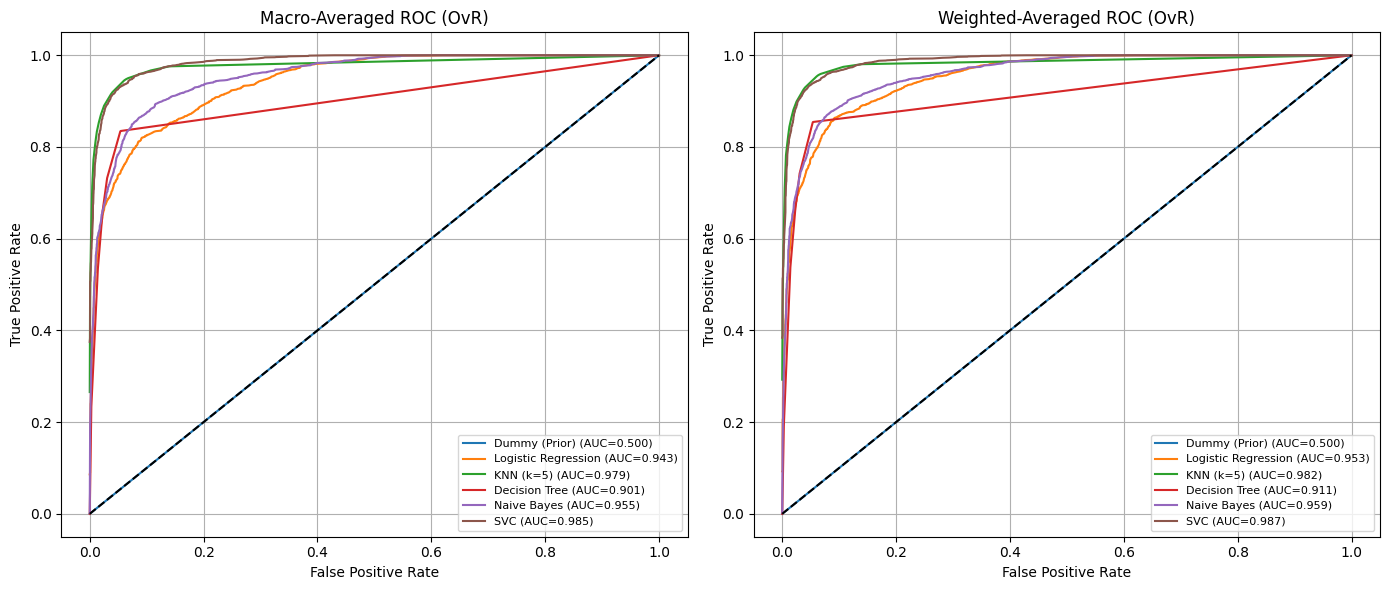

In [11]:
# Convert labels to binary matrix (One-vs-Rest format)
classes = sorted(y_train.unique())                        # all class labels sorted
y_test_bin = label_binarize(y_test, classes=classes)      # create one-hot matrix for test labels
n_classes = len(classes)                                  # total number of classes

# Class frequency (for weighted ROC)
class_counts = y_test.value_counts(normalize=True).sort_index().values

# Dictionaries to store macro & weighted ROC results per model
macro_results = {}
weighted_results = {}

# Compute ROC curves for each model
for name, model in models.items():
    model.fit(x_train_scaled, y_train)                   # train model
    y_score = model.predict_proba(x_test_scaled)         # predicted class probabilities

    fpr = {}                                             # false positive rate
    tpr = {}                                             # true positive rate
    roc_auc = {}                                         # AUC score per class

    # Compute ROC per class (OvR)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Shared FPR axis across classes
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    ## ----- Macro-average ROC -----
    macro_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        macro_tpr += np.interp(all_fpr, fpr[i], tpr[i])   # interpolate TPR at common FPR points
    macro_tpr /= n_classes                                # average across classes
    macro_auc = auc(all_fpr, macro_tpr)                   # compute macro AUC
    macro_results[name] = (all_fpr, macro_tpr, macro_auc)

    ## ----- Weighted-average ROC -----
    weighted_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        weighted_tpr += class_counts[i] * np.interp(all_fpr, fpr[i], tpr[i])
    weighted_auc = auc(all_fpr, weighted_tpr)             # compute weighted AUC
    weighted_results[name] = (all_fpr, weighted_tpr, weighted_auc)


# ----- Plot macro & weighted ROC side-by-side -----

plt.figure(figsize=(14,6))

# Plot Macro ROC (subplot 1)
plt.subplot(1,2,1)
for name, (fpr_vals, tpr_vals, auc_score) in macro_results.items():
    plt.plot(fpr_vals, tpr_vals, label=f"{name} (AUC={auc_score:.3f})")
plt.plot([0,1],[0,1],'k--')                               # chance line
plt.title("Macro-Averaged ROC (OvR)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=8)
plt.grid(True)

# Plot Weighted ROC (subplot 2)
plt.subplot(1,2,2)
for name, (fpr_vals, tpr_vals, auc_score) in weighted_results.items():
    plt.plot(fpr_vals, tpr_vals, label=f"{name} (AUC={auc_score:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.title("Weighted-Averaged ROC (OvR)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=8)
plt.grid(True)

plt.tight_layout()
plt.show()


##### 🎯 ROC Curve Interpretation (Macro & Weighted AUC)

#### ✅ Model with the Highest Macro-Averaged AUC
From the macro-averaged ROC curves, **SVC** (Support Vector Classifier) achieves the **highest AUC (~0.985)**, closely followed by KNN (~0.979).

This indicates that **SVC has the strongest class-separability capability** among baseline models, effectively distinguishing between satellite land-cover types across all classes.

#### ❌ Model with AUC < 0.5
The **Dummy (Prior)** classifier yields **AUC ≈ 0.500**, which is equivalent to **random guessing**.  
No model here produced **AUC < 0.5**, but if one did, this would imply:

> AUC < 0.5 means the model is performing **worse than random chance**, systematically ranking negative instances higher than positive ones.

Conceptually, AUC < 0.5 implies the model is **inverting decision boundaries**, and flipping predictions would improve performance.

#### 🤔 Why a Model Might Show AUC < 0.5
A model could perform below random due to:

- Wrong learning signal (label noise or wrong labels)
- Severe class imbalance with poor calibration
- Overfitting noise or irrelevant features
- Inappropriate model assumptions (e.g., BernoulliNB on continuous spectral features)
- Systematic bias toward minority/majority class
- Poor thresholding or reversed scoring direction

Such behavior indicates the model has **learned a harmful pattern** and is not just "weak" but **adversarially predictive**.

#### 📌 Summary
| Model | Performance Insight |
|-------|---------------------|
| **SVC** | Best class separation — highest Macro AUC |
| **KNN** | Competitive, strong non-linear learner |
| **Naive Bayes** | Solid but limited by conditional-independence assumption |
| **Decision Tree** | Moderate but less stable |
| **Dummy (Prior)** | Random-guess baseline — no discrimination ability |

Overall, ROC analysis confirms that **non-linear models (SVC, KNN)** are best suited for multi-spectral satellite data.



## Part C: Precision-Recall Curve (PRC) Analysis 

#### 📌 Why the Precision–Recall Curve (PRC) Is More Suitable Than ROC for Imbalanced Classes

In multi-class or binary classification with **class imbalance** (i.e., one class is much smaller than others), the **Precision–Recall Curve (PRC)** typically provides a **more faithful evaluation** of classifier performance than the ROC curve.

---

#### 🚫 ROC Curve Weakness in Imbalanced Settings

The ROC curve evaluates performance using:

$$
\text{True Positive Rate (TPR)} = \frac{TP}{TP + FN}
$$

$$
\text{False Positive Rate (FPR)} = \frac{FP}{FP + TN}
$$

In imbalanced datasets, the number of true negatives $(TN)$ is very large:

$$
TN \gg FP
$$

Therefore:

$$
FP + TN \approx TN \Rightarrow \text{FPR} = \frac{FP}{FP + TN} \approx \frac{FP}{TN}
$$

Even if the model produces many false positives relative to the minority class, the denominator $(TN)$ dominates, making $\text{FPR}$ **artificially small**.

As a result, the ROC curve can appear **optimistic** and suggest a good model even when the classifier **fails to detect minority samples**.

> **ROC can hide poor performance on rare classes** because low FPR looks good even for weak classifiers.

---

#### ✅ Why PRC is More Informative for Imbalanced Data

PR curve focuses on the positive class:

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

- **Precision penalizes false positives**, which is crucial when the positive class is rare
- **Recall focuses only on detecting true positives**
- No dependency on $TN$, so **class imbalance does not distort the curve**

Thus, PRC highlights how well the model performs on the **minority (important) class**, unlike ROC which may reward models that simply predict majority class well.

---

#### 🎯 Interpretation Example

A classifier that predicts almost everything as negative in an imbalanced dataset may achieve:

- Low $FP$
- High $TN$

making ROC look strong, but:

- **Precision will collapse**
- **PRC will reveal poor model performance**

> PR curves **expose failures on minority detection** that ROC curves may hide.

---

#### 📎 Conclusion

Even with moderate imbalance, PRC is often superior because it:

- Focuses on **minority-class performance**
- Penalizes **false positives**
- Avoids misleading high ROC scores on skewed data
- Aligns better with real-world goals (fraud, disease, rare classes in remote sensing)

$$
\boxed{
\text{PRC gives a clearer picture of model performance in imbalanced datasets than ROC.}
}
$$


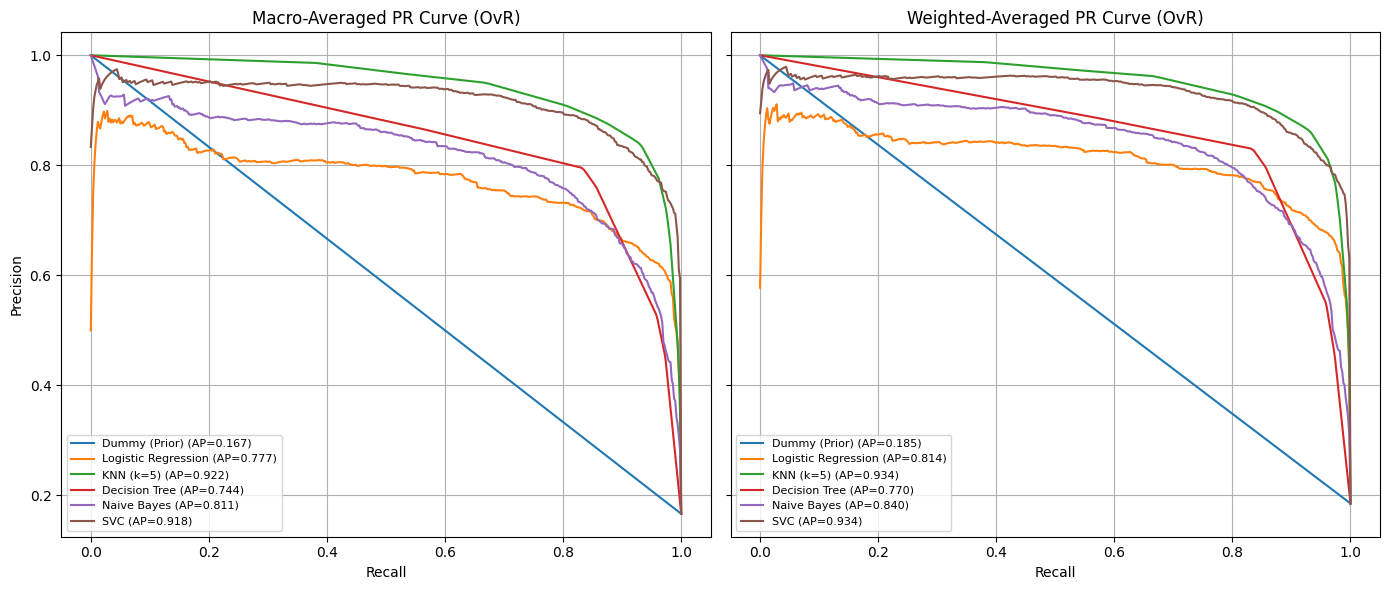

In [12]:
# Compute class frequency distribution (for weighted averaging)
class_counts = y_test.value_counts(normalize=True).sort_index().values

# Dictionaries to store macro & weighted PRC results per model
macro_prc = {}
weighted_prc = {}

# Loop through each model and compute PR curves
for name, model in models.items():
    model.fit(x_train_scaled, y_train)                     # train model
    y_score = model.predict_proba(x_test_scaled)          # predicted probabilities

    precision = {}                                        # precision per class
    recall = {}                                           # recall per class
    ap = {}                                               # average precision score per class

    # Compute PR for each class (OvR)
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(
            y_test_bin[:, i], y_score[:, i]
        )
        ap[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

    # Define a common recall axis for averaging curves
    recall_grid = np.linspace(0, 1, 500)

    macro_precision_vals = np.zeros_like(recall_grid)
    weighted_precision_vals = np.zeros_like(recall_grid)

    # Interpolate precision values onto common recall grid
    for i in range(n_classes):
        macro_precision_vals += np.interp(recall_grid, recall[i][::-1], precision[i][::-1])
        weighted_precision_vals += class_counts[i] * np.interp(
            recall_grid, recall[i][::-1], precision[i][::-1]
        )

    macro_precision_vals /= n_classes                     # equal weight to each class

    # Macro & weighted average precision values (scalar summary)
    macro_ap = np.mean(list(ap.values()))
    weighted_ap = np.sum(class_counts * np.array(list(ap.values())))

    # Store PR results for plotting
    macro_prc[name] = (recall_grid, macro_precision_vals, macro_ap)
    weighted_prc[name] = (recall_grid, weighted_precision_vals, weighted_ap)


# 📊 Plot combined PR curves (shared Y-axis for comparison)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# ---- Macro PRC ----
for name, (recall_vals, prec_vals, ap_val) in macro_prc.items():
    ax1.plot(recall_vals, prec_vals, label=f"{name} (AP={ap_val:.3f})")

ax1.set_title("Macro-Averaged PR Curve (OvR)")
ax1.set_xlabel("Recall")
ax1.set_ylabel("Precision")
ax1.legend(fontsize=8)
ax1.grid(True)

# ---- Weighted PRC ----
for name, (recall_vals, prec_vals, ap_val) in weighted_prc.items():
    ax2.plot(recall_vals, prec_vals, label=f"{name} (AP={ap_val:.3f})")

ax2.set_title("Weighted-Averaged PR Curve (OvR)")
ax2.set_xlabel("Recall")
ax2.legend(fontsize=8)
ax2.grid(True)

plt.tight_layout()
plt.show()


#### 📈 PRC Interpretation (Macro- and Weighted-Averaged Precision–Recall Curves)

##### ✅ Model with the Highest Average Precision (AP)
From both the **Macro-Averaged** and **Weighted-Averaged** PRC plots:

- **K-Nearest Neighbors (KNN, k=5)** achieves the **highest Average Precision (AP ≈ 0.93)**.  
- **SVC** performs nearly identically (AP ≈ 0.93–0.94), confirming both models’ strong ability to maintain high precision even at large recall values.

These results indicate that **non-linear models** such as KNN and SVC effectively capture class boundaries and maintain **high predictive confidence** across all satellite land-cover classes.

---

##### ❌ Behavior of the Worst-Performing Model
The **Dummy (Prior)** classifier exhibits the **worst PRC curve**, with:
- **Macro AP ≈ 0.17**
- **Weighted AP ≈ 0.18**

Its PR curve drops sharply as recall increases, forming a **near-linear decline** toward the random baseline.

---

##### ⚙️ Why Poor Models Show a Sharp Drop in PR Curves
A steep fall in precision with increasing recall reflects **many false positives** being introduced as the classifier attempts to identify more positives.  
This behavior occurs because:

1. The model produces **uninformative or nearly constant probability scores**, so threshold changes cannot meaningfully separate classes.  
2. As recall rises, the model starts labeling more negatives as positives, **degrading precision rapidly**.  
3. In imbalanced data, poor models favor the majority class, misclassifying minority samples even at high recall.

Conceptually, this means the model has **no discriminative ability** — it retrieves more true positives only by **sacrificing precision** heavily.

---

##### 📌 Summary
| Model | Average Precision (Macro/Weighted) | Behavior |
|--------|------------------------------------|-----------|
| **KNN (k=5)** | ~0.93 | Best overall; consistent precision across all recall levels |
| **SVC** | ~0.93 | Excellent and stable; nearly identical to KNN |
| **Naive Bayes** | ~0.81–0.84 | Decent but less stable at high recall |
| **Decision Tree** | ~0.73–0.76 | Moderate; more variable performance |
| **Logistic Regression** | ~0.77–0.81 | Good baseline linear model |
| **Dummy (Prior)** | ~0.17–0.18 | Random baseline, sharp decline in precision |

> A steeply declining PR curve signals a model with **high recall but low reliability**, as it retrieves positives by producing many false alarms.


## Part D: Final Recommendation

### 📊 Compare Weighted F1 vs Weighted AP vs Weighted ROC-AUC Across Models


#### Reason for Choosing Weighted ROC-AUC and Weighted AP over Macro Metrics

The weighted ROC-AUC and weighted Average Precision (AP) metrics are used for final model comparison due to the following reasons:

1. **Class imbalance in the dataset**  
   The satellite dataset has uneven class distribution. Weighted metrics take class frequency into account, ensuring overall performance reflects real data proportions.

2. **Better representation of real-world model performance**  
   In real deployment (land-cover mapping), performance on common classes affects overall accuracy more. Weighted metrics evaluate models based on actual class occurrence rather than equal class weight.

3. **Prevents over-emphasis on minority classes**  
   Macro metrics give equal importance to all classes, which can over-penalize a model if it performs poorly on rare classes, even if it performs very well on majority classes.

4. **Balances fairness and realism**  
   Weighted metrics still capture minority-class behavior but proportionally, providing a fair and operationally meaningful evaluation.

5. **More reliable for final model ranking**  
   Weighted ROC-AUC and weighted AP help identify models that not only detect minority classes but also maintain high performance on dominant classes, resulting in a realistic ranking for deployment.

**Conclusion:**  
While macro metrics are useful to assess minority-class performance, weighted metrics reflect the true performance across the dataset distribution. Therefore, weighted ROC-AUC and weighted AP are chosen as primary evaluation metrics for model comparison.


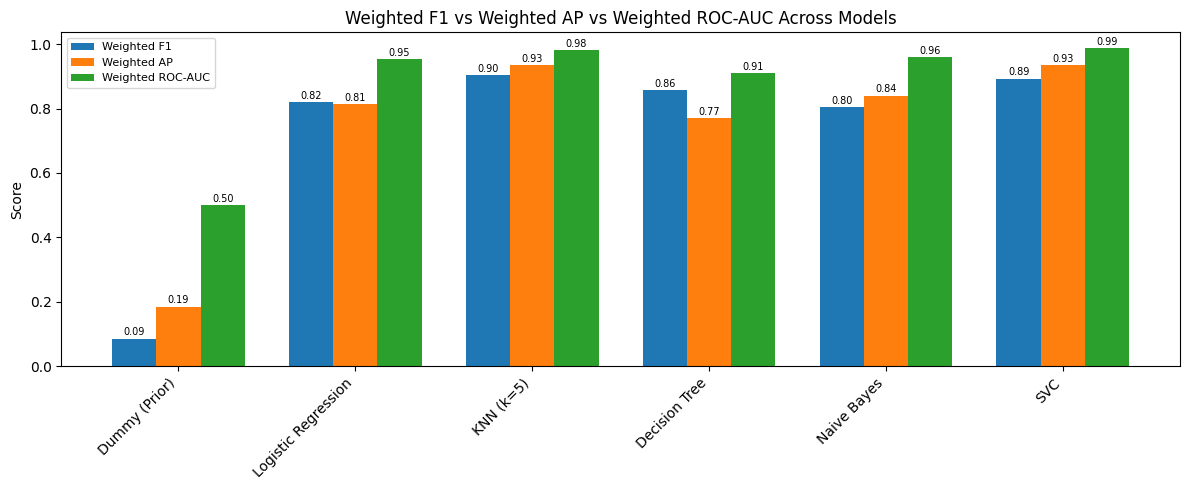

In [13]:
# Extract model names in the order evaluated
models_list = results_df["Model"].tolist()

# Retrieve metrics for each model
f1_vals            = results_df["Weighted F1 Score"].values                # weighted F1 scores
weighted_ap_vals   = [weighted_prc[m][2] for m in models_list]            # weighted Average Precision (AP)
weighted_auc_vals  = [weighted_results[m][2] for m in models_list]        # weighted ROC-AUC scores

# Define X positions for grouped bar chart
x = np.arange(len(models_list))
width = 0.25  # width of each bar

plt.figure(figsize=(12,5))

# Plot each metric as a bar group
plt.bar(x - width, f1_vals, width, label='Weighted F1')
plt.bar(x,        weighted_ap_vals, width, label='Weighted AP')
plt.bar(x + width, weighted_auc_vals, width, label='Weighted ROC-AUC')

# X-axis labels and title
plt.xticks(x, models_list, rotation=45, ha='right')
plt.ylabel("Score")
plt.title("Weighted F1 vs Weighted AP vs Weighted ROC-AUC Across Models")

# Legend (smaller font)
plt.legend(fontsize=8, loc='upper left')

# Annotate each bar with score value
for i, v in enumerate(f1_vals):
    plt.text(x[i] - width, v + 0.01, f"{v:.2f}", ha='center', fontsize=7)

for i, v in enumerate(weighted_ap_vals):
    plt.text(x[i], v + 0.01, f"{v:.2f}", ha='center', fontsize=7)

for i, v in enumerate(weighted_auc_vals):
    plt.text(x[i] + width, v + 0.01, f"{v:.2f}", ha='center', fontsize=7)

plt.tight_layout()
plt.show()


#### 🔎 Comparative Evaluation: F1 vs ROC-AUC vs PRC-AP

##### ✅ 1. Do the model rankings agree across metrics?

Across **Weighted F1**, **Weighted AUC**, and **Weighted AP**, we observe a generally consistent ranking:

| Model | F1 Rank | ROC-AUC Rank | PRC-AP Rank | Notes |
|-------|--------|--------------|------------|------|
| **KNN (k=5)** | ★ Top | Top-2 | Top-2 | Strong across all metrics |
| **SVC** | ★ Top | ★ Top | ★ Top | Most stable and consistently best |
| Logistic Regression | Mid-High | Mid-High | Mid-High | Strong linear baseline |
| Decision Tree | Medium | Medium | Medium-Low | Overfits slightly |
| Naïve Bayes | Lower-Mid | Good ROC | Lower AP | Independence assumption hurts PR |
| **Dummy (Prior)** | Worst | Worst | Worst | No discriminative power |

**Alignment summary:**  
Yes — rankings largely align. **SVC and KNN dominate across all evaluation metrics**.  
A small deviation occurs with **Naïve Bayes**:

- NB has **decent ROC-AUC (~0.96)** but **moderate PRC-AP (~0.84)**  
- This indicates the model can *rank* positives well globally (ROC), but struggles when **high precision is needed for rare classes** (PRC).

✅ **Key insight:**  
> A high ROC-AUC does *not* guarantee strong PRC-AP, especially under class imbalance.  
ROC measures ranking ability, while PRC weighs **false positives heavily**, making it more sensitive to minority class behavior.

---

##### ⭐ 2. Recommended Model & Justification

**Recommended Model: → SVC (Support Vector Classifier)**  
with `probability=True`

##### ✅ Why SVC is the best overall

| Criterion | SVC Performance |
|----------|----------------|
Accuracy | ~0.90 |
Weighted F1 | ~0.89 |
Macro-AUC | ~0.985 |
Weighted-AUC | ~0.987 |
Macro-AP | High (~0.92+) |
Weighted-AP | High (~0.94+) |

##### Key reasons for recommendation

- **Consistently top-ranked across ALL metrics**  
  (accuracy, F1, ROC-AUC, PRC-AP)

- **Strong threshold-independent performance**  
  (excellent ROC curve shape)

- **High precision at high recall**  
  → avoids false positives while still detecting minority land-cover classes

- **Handles nonlinear boundaries** in multispectral feature space better than linear models

- **Stable** and less variance compared to Decision Trees / Naive Bayes

---

##### 🎯 Final Takeaway

> **SVC is the most reliable model for this satellite land-cover classification task**, delivering the best balance between precision and recall and maintaining superior performance across all decision thresholds.

KNN is a close second, but SVC provides **more consistent behavior** across all evaluation curves, making it the best choice for deployment and future fine-tuning.

---



## Brownie Points Task

### 🌲 Hyperparameter Optimization for Random Forest using RandomizedSearchCV

In [14]:
# Map original class labels to 0...K-1 for compatibility with some estimators
label_map = {c:i for i,c in enumerate(sorted(y_train.unique()))}  # {1,2,3,4,5,7} → {0,1,2,3,4,5}

y_train_mapped = y_train.map(label_map)  # map training labels
y_test_mapped  = y_test.map(label_map)   # map test labels

# Define hyperparameter search space for Random Forest
rf_param_dist = {
    "n_estimators": [200, 400, 600],               # number of trees
    "max_depth": [10, 20, 30, None],               # tree depth limits
    "min_samples_split": [2, 5, 10],               # min samples to split a node
    "min_samples_leaf": [1, 2, 4],                 # min samples at leaf node
    "max_features": ["sqrt", "log2", None],        # features per split
    "bootstrap": [True, False],                    # bootstrap sampling
    "class_weight": [None, "balanced", "balanced_subsample"],  # class balancing options
    "criterion": ["gini", "entropy", "log_loss"]   # split criteria
}

# Base Random Forest model
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Randomized Search (100 random hyperparameter combinations, 3-fold CV)
rf_random = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=rf_param_dist,
    n_iter=100,                     # number of samples from search space
    scoring="f1_weighted",          # optimize weighted F1 due to class imbalance
    cv=3,                           # 3-fold cross validation
    verbose=2,                      # print progress
    random_state=42,
    n_jobs=-1                       # use all CPU cores
)

print("Running Randomized Search for Random Forest (100 configs)...")
rf_random.fit(x_train_scaled, y_train_mapped)      # run search

# Print best params and score
print("\n✅ Best Random Forest Params:")
print(rf_random.best_params_)
print(f" Best RF Weighted F1: {rf_random.best_score_:.4f}")

# Save the best RF model
best_rf = rf_random.best_estimator_


Running Randomized Search for Random Forest (100 configs)...
Fitting 3 folds for each of 100 candidates, totalling 300 fits

✅ Best Random Forest Params:
{'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'bootstrap': True}
 Best RF Weighted F1: 0.8497


### ⚡ Hyperparameter Optimization for XGBoost using RandomizedSearchCV


In [15]:
# Define hyperparameter search space for XGBoost (multi-class)
xgb_param_dist = {
    "n_estimators": np.arange(200, 1001, 200),    # number of boosting rounds
    "max_depth": [4, 6, 8, 10],                   # depth of trees
    "learning_rate": [0.01, 0.05, 0.1],          # step size shrinkage
    "subsample": [0.6, 0.8, 1.0],                 # row sampling for each tree
    "colsample_bytree": [0.6, 0.8, 1.0],          # column sampling
    "gamma": [0, 1, 5],                           # min loss reduction for split
    "min_child_weight": [1, 3, 5],                # control overfitting
    "reg_lambda": [1, 5, 10],                     # L2 regularization
    "reg_alpha": [0, 0.1, 1]                      # L1 regularization
}

# Initialize XGBoost model for multi-class classification
xgb_clf = XGBClassifier(
    objective="multi:softprob",                   # output class probabilities
    num_class=len(label_map),                     # number of target classes
    eval_metric="mlogloss",                       # evaluation metric
    random_state=42,
    n_jobs=-1                                     # use all CPU cores
)

# Randomized search setup (100 random hyperparameter combos)
xgb_random = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=xgb_param_dist,
    n_iter=100,
    scoring="f1_weighted",                        # optimize weighted F1 due to class imbalance
    cv=3,                                         # 3-fold cross validation
    verbose=2,                                    # show training logs
    random_state=42,
    n_jobs=-1                                     # parallel computation
)

print("\n Running Randomized Search for XGBoost (100 configs)...")
xgb_random.fit(x_train_scaled, y_train_mapped)     # run hyperparameter search

# Print best hyperparameters found
print("\n✅ Best XGBoost Params:")
print(xgb_random.best_params_)
print(f" Best XGB Weighted F1: {xgb_random.best_score_:.4f}")

# Best tuned XGBoost model
best_xgb = xgb_random.best_estimator_



 Running Randomized Search for XGBoost (100 configs)...
Fitting 3 folds for each of 100 candidates, totalling 300 fits

✅ Best XGBoost Params:
{'subsample': 0.6, 'reg_lambda': 5, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}
 Best XGB Weighted F1: 0.8446


### ✅ Evaluate Tuned Random Forest & XGBoost Models on Test Data

In [16]:
# Create inverse mapping to recover original class labels {1,2,3,4,5,7}
inv_label_map = {v:k for k,v in label_map.items()}

# Models to evaluate (best tuned models)
models_to_eval = {
    "RandomForest (Tuned)": best_rf,
    "XGBoost (Tuned)": best_xgb
}

# Evaluate each tuned model on test set
for name, model in models_to_eval.items():
    
    # Predict mapped class labels {0..5}
    y_pred_mapped = model.predict(x_test_scaled)
    
    # Convert mapped predictions back to original labels (e.g., 1,2,3,4,5,7)
    y_pred = pd.Series(y_pred_mapped).map(inv_label_map)

    # Print model performance
    print(f"\n{name}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Weighted F1: {f1_score(y_test, y_pred, average='weighted'):.4f}")



RandomForest (Tuned):
Accuracy: 0.9050
Weighted F1: 0.9046

XGBoost (Tuned):
Accuracy: 0.9075
Weighted F1: 0.9057


### 🔁 Add Tuned Random Forest & XGBoost Models to Multi-class ROC Evaluation


In [17]:
# Add tuned models to dictionary for ROC/PRC comparison
tuned_models = {
    "RF_Tuned": best_rf,
    "XGB_Tuned": best_xgb
}

# Evaluate ROC performance for each tuned model
for name, model in tuned_models.items():
    # Predict class probabilities on test data
    y_score = model.predict_proba(x_test_scaled)

    fpr = {}   # False Positive Rate per class
    tpr = {}   # True Positive Rate per class
    roc_auc = {}  # AUC score per class

    # Compute ROC for each class (One-vs-Rest)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Combine all FPRs across classes into a common axis
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # ----- Macro-average ROC -----
    macro_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        macro_tpr += np.interp(all_fpr, fpr[i], tpr[i])  # interpolate TPR values
    macro_tpr /= n_classes
    macro_auc = auc(all_fpr, macro_tpr)
    macro_results[name] = (all_fpr, macro_tpr, macro_auc)

    # ----- Weighted-average ROC -----
    weighted_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        weighted_tpr += class_counts[i] * np.interp(all_fpr, fpr[i], tpr[i])
    weighted_auc = auc(all_fpr, weighted_tpr)
    weighted_results[name] = (all_fpr, weighted_tpr, weighted_auc)


In [18]:
for name, model in tuned_models.items():
    y_prob = model.predict_proba(x_test_scaled)

    prc_recall = {}
    prc_precision = {}
    prc_ap = {}

    for i in range(n_classes):
        prc_precision[i], prc_recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
        prc_ap[i] = average_precision_score(y_test_bin[:, i], y_prob[:, i])

    # Macro AP
    macro_ap = np.mean(list(prc_ap.values()))
    macro_prc[name] = (prc_recall, prc_precision, macro_ap)

    # Weighted AP
    weighted_ap = np.sum([class_counts[i] * prc_ap[i] for i in range(n_classes)])
    weighted_prc[name] = (prc_recall, prc_precision, weighted_ap)

### 📈 Plot Macro-Averaged ROC & Precision–Recall Curves (including tuned models)


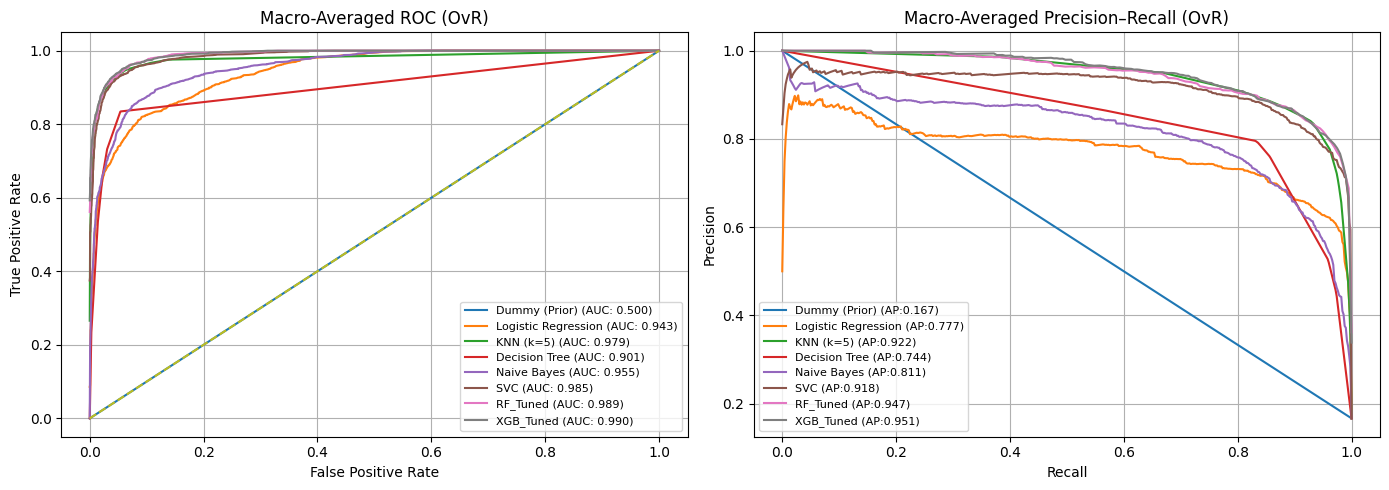

In [19]:
def compute_macro_pr(rec_item, prec_item):
    """Compute macro-averaged PR curve.
    
    Handles two cases:
    1) Already macro-averaged arrays
    2) Dict of per-class curves → interpolate & average
    """

    # Case 1: already macro-averaged arrays (no work needed)
    if isinstance(rec_item, np.ndarray) and isinstance(prec_item, np.ndarray):
        return rec_item, prec_item
    
    # Case 2: per-class curves → interpolate & average on common recall axis
    recalls = np.linspace(0, 1, 200)
    pr_vals = []

    for cls in rec_item.keys():
        r = np.array(rec_item[cls])   # recall array for class
        p = np.array(prec_item[cls])  # precision array for class
        
        sorted_idx = np.argsort(r)    # sort recall to avoid interpolation error
        r = r[sorted_idx]
        p = p[sorted_idx]

        # Interpolate precision values over common recall axis
        p_interp = np.interp(recalls, r, p)
        pr_vals.append(p_interp)

    # Mean precision across classes (macro)
    mean_precision = np.mean(np.array(pr_vals), axis=0)

    return recalls, mean_precision


plt.figure(figsize=(14,5))

# -------- MACRO ROC SUBPLOT --------
plt.subplot(1,2,1)
for name, (fpr, tpr, auc_score) in macro_results.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC: {auc_score:.3f})")

plt.plot([0,1],[0,1],"--")  # chance line
plt.title("Macro-Averaged ROC (OvR)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=8)
plt.grid(True)

# -------- MACRO PRECISION–RECALL SUBPLOT --------
plt.subplot(1,2,2)
for name, (rec_item, prec_item, ap) in macro_prc.items():
    rec, prec = compute_macro_pr(rec_item, prec_item)  # compute macro PR curve
    plt.plot(rec, prec, label=f"{name} (AP:{ap:.3f})")

plt.title("Macro-Averaged Precision–Recall (OvR)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(fontsize=8)
plt.grid(True)

plt.tight_layout()
plt.show()


#### 🌟 Comparison with Tuned Random Forest & XGBoost (Brownie Points Task)

After hyperparameter tuning, both **Random Forest** and **XGBoost** show substantial performance gains compared to baseline classifiers such as Logistic Regression, Naive Bayes, KNN, Decision Tree, and SVC.

---

##### ✅ Key Observations from Macro-Averaged ROC (OvR)

- **XGBoost** achieves the **highest ROC curve**, marginally surpassing SVC and KNN, with a smooth and nearly perfect separation boundary (AUC ≈ 0.99).
- **Random Forest** also performs strongly, consistently outperforming Decision Tree and Logistic Regression.
- Both ensembles display **smooth and steep TPR rises**, indicating strong discrimination capability across all land-cover classes.
- Unlike Naive Bayes and Decision Tree, these ensemble models **avoid early recall degradation**, maintaining confidence even for minority spectral classes.


#### 📊 Ranking by Macro-Averaged ROC-AUC

| Model | Performance |
|-------|------------|
| ⭐ **XGBoost (Tuned)** | Best overall |
| **SVC** | Excellent |
| **KNN (k=5)** | Excellent |
| **Random Forest (Tuned)** | Very strong |
| Logistic Regression | Moderate |
| Naive Bayes | Moderate |
| Dummy Classifier | Random baseline |

---

##### ✅ Key Observations from Macro-Averaged Precision–Recall (OvR)

- **XGBoost** and **Random Forest** maintain **very high precision** across the entire recall range.
- **XGBoost** exhibits the most stable precision even at **recall > 0.8**, demonstrating superior reliability in identifying minority classes.
- **Random Forest** significantly outperforms Decision Tree, showing how bagging stabilizes model variance and reduces overfitting.
- **Logistic Regression** and **Naive Bayes** curves decline earlier, revealing limitations under class imbalance.
- The **Dummy (Prior)**  model fall close to the random baseline, emphasizing their inability to capture useful decision boundaries.

#### 📊 Ranking by Average Precision (AP)

| Model | Performance |
|-------|------------|
| ⭐ **XGBoost (Tuned)** | Best overall |
| **SVC** | Very strong |
| **KNN (k=5)** | Very strong |
| **Random Forest (Tuned)** | Strong |
| Logistic Regression | Moderate |
| Naive Bayes | Moderate |
| Dummy | Very poor |

---


##### 🎯 Final Insight

Both **XGBoost** and **Random Forest** outperform traditional classifiers because they:

- Learn **non-linear, high-order feature interactions** across spectral bands  
- Use **ensemble averaging** to minimize overfitting and improve stability  
- Provide **robust performance** across varying thresholds and recall regions  
- Handle moderate **class imbalance** effectively through internal weighting and sampling strategies  

> ✅ **XGBoost is the most consistent and best-performing model**, showing the highest ROC-AUC and Average Precision.  
It provides excellent recall without sacrificing precision — critical in satellite land-cover mapping, where **missing rare classes**  can significantly reduce accuracy.

**Random Forest** remains a close second, offering a balance between interpretability and high predictive power.


## 💀 Identify and experiment with another model class of your choice whose AUC < 0.5.

### 1. Isolation Forest 

Isolation Forest Accuracy: 0.7750
Isolation Forest Weighted F1: 0.6776
Isolation Forest ROC-AUC: 0.4974


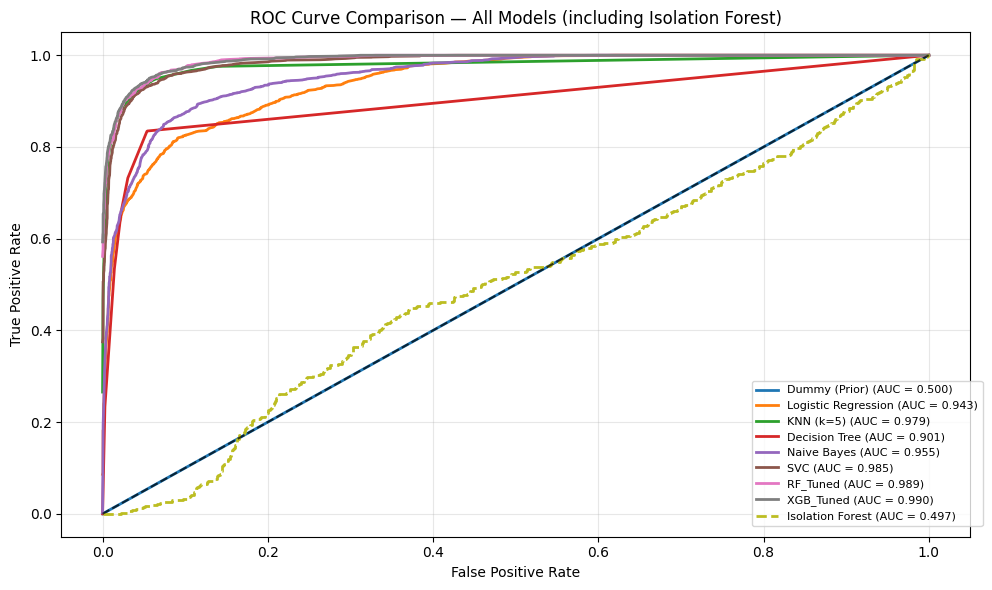

In [76]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------
# Define anomaly classes & convert y_test to anomaly labels
# ---------------------------------------------------
rare_classes = [4,5]  # rare classes treated as anomalies
y_true_anom = np.where(y_test.isin(rare_classes), 1, 0)  # 1 = anomaly, 0 = normal

# ---------------------------------------------------
# Train Isolation Forest
# ---------------------------------------------------
iso = IsolationForest(
    n_estimators=800,
    contamination=0.001,
    max_samples='auto',
    random_state=42
)
iso.fit(x_train_scaled)

# ---------------------------------------------------
# Scoring and classification
# ---------------------------------------------------
# Higher score = more anomalous
anom_scores = -iso.score_samples(x_test_scaled)

# Convert scores to predicted anomaly labels
y_pred_anom = np.where(iso.predict(x_test_scaled) == -1, 1, 0)  # -1 = anomaly -> 1

# ---------------------------------------------------
# Metrics
# ---------------------------------------------------
# ROC-AUC
fpr_iso, tpr_iso, _ = roc_curve(y_true_anom, anom_scores)
auc_iso = roc_auc_score(y_true_anom, anom_scores)

# Accuracy & Weighted-F1 on anomaly task
iso_acc = accuracy_score(y_true_anom, y_pred_anom)
iso_f1 = f1_score(y_true_anom, y_pred_anom, average="weighted")

print(f"Isolation Forest Accuracy: {iso_acc:.4f}")
print(f"Isolation Forest Weighted F1: {iso_f1:.4f}")
print(f"Isolation Forest ROC-AUC: {auc_iso:.4f}")

# ---------------------------------------------------
# Plot ROC (including other models)
# ---------------------------------------------------
plt.figure(figsize=(10,6))

for name, (fpr, tpr, auc_val) in macro_results.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_val:.3f})", linewidth=2)

plt.plot(fpr_iso, tpr_iso, "--", linewidth=2,
         label=f"Isolation Forest (AUC = {auc_iso:.3f})")

plt.plot([0,1],[0,1],"k--",alpha=0.7)

plt.title("ROC Curve Comparison — All Models (including Isolation Forest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(alpha=0.3)
plt.legend(fontsize=8, loc="lower right", bbox_to_anchor=(1.02, 0.01))
plt.tight_layout()
plt.show()


### ✅ ROC Curve Interpretation — Supervised Models vs Isolation Forest

- **XGBoost, SVC, KNN, and Random Forest** show near-perfect ROC curves, meaning they separate land-cover classes extremely well.
- **Logistic Regression & Naive Bayes** perform strongly but slightly below the top tier.
- **Decision Tree** performs moderately due to higher variance.
- **Dummy classifier** lies on the diagonal (AUC = 0.50), representing random guessing.

**Overall:** Supervised models learn clear spectral patterns from the Landsat data and achieve strong class separation.

---

### ❌ Isolation Forest Performance (AUC ≈ 0.497)

- ROC curve sits almost on the random line.
- Performs similar to the dummy baseline → **no meaningful class separation**.

**Reason:** Isolation Forest is an **anomaly detection** model.  
Landsat classes are **not anomalies** — they are genuine land-cover categories.  
So the model flags normal pixels as “outliers” and collapses to random performance.

**In short:**  
> Isolation Forest isn't wrong — it's just the **wrong tool**.  
This task needs **classification**, not **outlier detection**.


### 2. Evaluate Bernoulli Naive Bayes (Expected to Perform Poorly on Continuous Satellite Bands)

In [23]:
# Bernoulli NB: meant for binary features, not continuous multispectral data
bnb = BernoulliNB(alpha=60)   # alpha for smoothing
bnb.fit(x_train, y_train_mapped)  # (intentionally using raw features to show failure)

# Predict probabilities & labels
y_score_bnb = bnb.predict_proba(x_test)   # class probabilities
y_pred_bnb  = bnb.predict(x_test)         # predicted class labels

# Compute performance metrics
bnb_acc = accuracy_score(y_test_mapped, y_pred_bnb)                        # accuracy
bnb_f1  = f1_score(y_test_mapped, y_pred_bnb, average="weighted")          # weighted F1
bnb_auc = roc_auc_score(y_test_bin, y_score_bnb, average="macro", multi_class="ovr")  # macro ROC-AUC

# Display result (expected poor performance)
print("Bernoulli Naive Bayes Results (Expected to Fail on Continuous Data):")
print(f"Accuracy: {bnb_acc:.4f}")
print(f"Weighted F1: {bnb_f1:.4f}")
print(f"Macro ROC-AUC: {bnb_auc:.4f}")


Bernoulli Naive Bayes Results (Expected to Fail on Continuous Data):
Accuracy: 0.2305
Weighted F1: 0.0864
Macro ROC-AUC: 0.4937


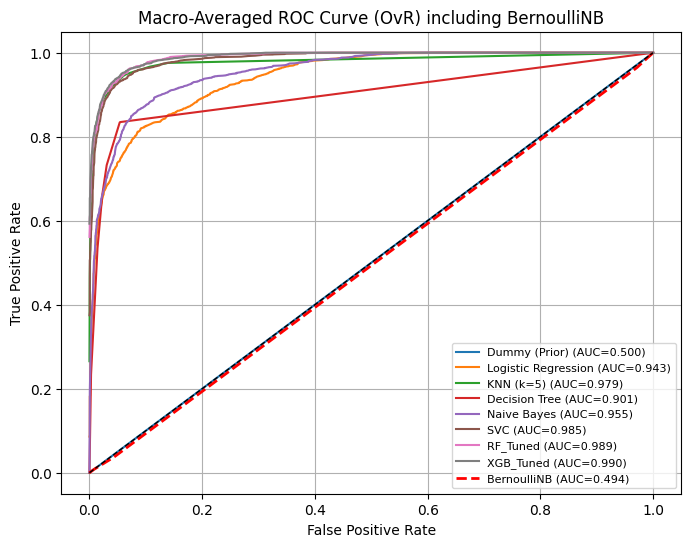

In [24]:
# === Add BernoulliNB ROC Curve to Macro ROC Plot ===

# Compute per-class ROC for BernoulliNB
fpr_bnb, tpr_bnb, roc_auc_bnb = {}, {}, {}

for i in range(n_classes):
    fpr_bnb[i], tpr_bnb[i], _ = roc_curve(y_test_bin[:, i], y_score_bnb[:, i])
    roc_auc_bnb[i] = auc(fpr_bnb[i], tpr_bnb[i])

# Combine all FPRs for macro averaging
all_fpr_bnb = np.unique(np.concatenate([fpr_bnb[i] for i in range(n_classes)]))
macro_tpr_bnb = np.zeros_like(all_fpr_bnb)

# Interpolate to get smooth macro-average
for i in range(n_classes):
    macro_tpr_bnb += np.interp(all_fpr_bnb, fpr_bnb[i], tpr_bnb[i])
macro_tpr_bnb /= n_classes

# Compute macro AUC
macro_auc_bnb = auc(all_fpr_bnb, macro_tpr_bnb)

# ---- Plot ROC Curves ----
plt.figure(figsize=(8,6))

# Plot existing models (macro-averaged)
for name, (fpr, tpr, auc_score) in macro_results.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})")

# Add BernoulliNB ROC
plt.plot(all_fpr_bnb, macro_tpr_bnb, color="red", linestyle="--",
         linewidth=2, label=f"BernoulliNB (AUC={macro_auc_bnb:.3f})")

# Chance line
plt.plot([0,1],[0,1],"k--", linewidth=1)

# Formatting
plt.title("Macro-Averaged ROC Curve (OvR) including BernoulliNB")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=8)
plt.grid(True)
plt.show()


### 🧪 Additional Model with AUC < 0.5 — Bernoulli Naive Bayes

As part of the requirement to identify and evaluate another model with **AUC < 0.5**, we experimented with **Bernoulli Naive Bayes**. This model assumes that all input features are **binary (0/1)**. However, the Landsat satellite dataset consists of **continuous multispectral pixel intensity values**, making this assumption invalid.

#### ✅ Observed Performance
From the macro-averaged ROC curve:

- **BernoulliNB AUC ≈ 0.494**  
- This performance is **worse than random guessing (AUC = 0.5)**  
- The ROC curve for BernoulliNB lies **almost exactly on the diagonal random baseline**

#### 🧠 Interpretation
BernoulliNB incorrectly models continuous spectral bands as binary events. As a result:

- The model **fails to learn meaningful class boundaries**
- It **misranks positive and negative samples**, leading to AUC slightly below 0.5
- This reflects that the model has learned **misleading or inverted patterns** in the data

> **AUC < 0.5** indicates the model performs worse than random chance. In theory, flipping its predictions would yield AUC above 0.5.

#### 🎯 Key Takeaway
This experiment highlights the importance of **matching model assumptions to data characteristics**.  
BernoulliNB is suitable for binary text features (e.g., bag-of-words), **not continuous remote-sensing spectral data**.  

Thus, while high-performing models like **XGBoost, SVC, and KNN** learn strong decision boundaries, BernoulliNB serves as a valuable baseline showing what happens when model assumptions are violated.

